In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataloader

In [2]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import time

import glob
import matplotlib.pyplot as plt
import cv2


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.manual_seed(0)

In [3]:
class myDataset(Dataset):
    
    def __init__(self, root, _transforms = None):
        
        self.transform = transforms.Compose(_transforms)
        
        self.domain_A_files = glob.glob(os.path.join(root, "photo_jpg", "*.jpg"))
        self.domain_B_files = glob.glob(os.path.join(root, "monet_jpg", "*.jpg"))
        
    def __len__(self):
        
        return(max(len(self.domain_A_files), len(self.domain_B_files)))
             
    def __getitem__(self, ind):
        
        item_A = self.transform(Image.open(self.domain_A_files[ind % len(self.domain_A_files)]))
        
        item_B = self.transform(Image.open(self.domain_B_files[random.randint(0, len(self.domain_B_files) - 1)]))
        
        return {"A":item_A, "B":item_B}

In [4]:
#Define Transforms

_transforms = [transforms.Resize((256,256)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]

In [5]:
root = "gan-getting-started"
DATASET = myDataset(root, _transforms)

In [6]:
dataloader = DataLoader(DATASET, batch_size = 1, shuffle = True)

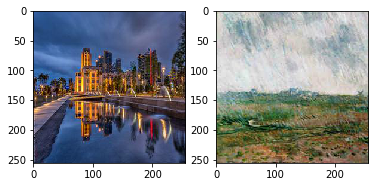

In [7]:
sample_set = next(iter(dataloader))
imageA = sample_set["A"][0]
imageA = imageA.permute(1,2,0)

imageB = sample_set["B"][0]
imageB = imageB.permute(1,2,0)

plt.subplot(1,2,1)
plt.imshow(imageA * 0.5 + 0.5)
plt.subplot(1,2,2)
plt.imshow(imageB * 0.5 + 0.5)

# Build Generator/ Discriminator

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [10]:
class Generator(nn.Module):
    
    def __init__(self, in_size, out_size, n_res_blocks):
        
        super (Generator, self).__init__()
        
        layers = []
        
        # 64*7*7 conv layer, stride 1, pad 3
        layer1 = [nn.ReflectionPad2d(3), 
                  nn.Conv2d(in_size, 64, 7, 1),
                  nn.InstanceNorm2d(64),
                  nn.ReLU(inplace = True)]
        
        layers.extend(layer1)
        
        # 128*3*3, stride 2, pad 1
        
        layer2 = [nn.Conv2d(64, 128, 3, 2, 1),
                 nn.InstanceNorm2d(128),
                 nn.ReLU(inplace = True)
                 ]
        
        layers.extend(layer2)
        
        # 256*3*3, stride 2, pad 1
        layer3 = [nn.Conv2d(128, 256, 3, 2,1),
                 nn.InstanceNorm2d(256),
                 nn.ReLU(inplace = True)]
        
        layers.extend(layer3)
        
        # Res blocks
        for i in range(n_res_blocks):            
            layers.extend(ResidualBlock(256).conv_block)
        
            
        #128*3*3 convtranspose stride 2, pad 1, out_pad 1
        #layer5 = [nn.ConvTranspose2d(256,128, 3, 2, 1, 1),
        #  nn.InstanceNorm2d(128),
        #  nn.ReLU(inplace = True)]
        
        layer5 = [nn.Upsample(scale_factor = 2),
          nn.Conv2d(256, 128, 7, 1, 3),
          nn.InstanceNorm2d(128),
          nn.ReLU(inplace = True)] 
        
        layers.extend(layer5)
        
        
        #64*3*3 convtranspose stride2, pad1, out_pad1
        #change convtranspose to Upsample + Conv
        
        
        #layer6 = [nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
        #  nn.InstanceNorm2d(64),
        #  nn.ReLU(inplace = True)]
        
        layer6 = [nn.Upsample(scale_factor = 2),
          nn.Conv2d(128, 64, 7, 1, 3),
          nn.InstanceNorm2d(64),
          nn.ReLU(inplace = True)]       
        
        layers.extend(layer6)
        
        #3*7*7 conv, stride 1, pad 3
        
        layer7 = [nn.Conv2d(64, out_size, 7, 1, 3),
                 nn.Tanh()]
        
        layers.extend(layer7)
        
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x):
        
        return self.model(x)

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, in_size):
        super(Discriminator,self).__init__()
        
        layers = []
        
        # 64*4*4 conv, stride 2, pad 1
        layer1 = [nn.Conv2d(in_size, 64, 4, 2, 1),
                 nn.InstanceNorm2d(64),
                 nn.LeakyReLU(0.2, inplace = True)]
        layers.extend(layer1)
        # 128*4*4 conv, stride 2, pad 1
        layer2 = [nn.Conv2d(64,128,4,2,1),
                 nn.InstanceNorm2d(128),
                 nn.LeakyReLU(0.2,inplace = True)]
        layers.extend(layer2)
        # 256*4*4 conv, stride 2, pad 1
        layer3 = [nn.Conv2d(128,256,4,2,1),
                 nn.InstanceNorm2d(256),
                 nn.LeakyReLU(0.2,inplace = True)]
        layers.extend(layer3)
        # 521*4*4 conv, stride 1, pad 1
        layer4 = [nn.Conv2d(256, 521, 4, 1, 1),
                 nn.InstanceNorm2d(521),
                 nn.LeakyReLU(0.2, inplace = True)]
        layers.extend(layer4)
        # 1*4*4 conv, stride 1, pad 1
        layer5 = [nn.Conv2d(521, 1,4,1,1)]
        layers.extend(layer5)
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## 2.1 One-step test

In [12]:
batch = next(iter(dataloader))
real_photo = batch["A"].cuda()
real_monet = batch["B"].cuda()
Gan = Generator(3,3,9).cuda()
Dis_model = Discriminator(3).cuda()
gan_photo = Gan(real_photo)
dis_photo = Dis_model(real_photo)
print(gan_photo.shape)
print(dis_photo.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 30, 30])


In [32]:
def image_print(image):
    
    image = image[0]
    image = image.permute(1,2,0).cpu().detach().numpy()
    image = image * 0.5 + 0.5
    plt.imshow(image)

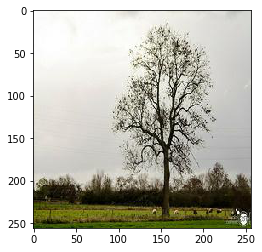

In [14]:
image_print(real_photo)

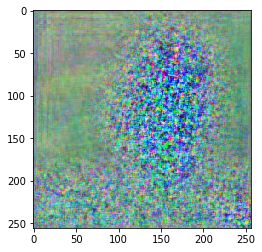

In [15]:
image_print(gan_photo)

# 3 Training

In [12]:
_batch_size = 1
_n_epoch = 30
_lr = 2e-4
_in_size = 3
_out_size = 3
_n_res = 9
_gan_mode = "lsgan"
_Lambda = 10

In [13]:
# Initialize Network
#from photo to image
Gan_A2B = Generator(_in_size, _out_size, _n_res)

#from image to photo
Gan_B2A = Generator(_out_size, _in_size, _n_res)

Dis_A = Discriminator(_in_size)
Dis_B = Discriminator(_out_size)

In [14]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [15]:
Gan_A2B.apply(weights_init_normal)
Gan_B2A.apply(weights_init_normal)
Dis_A.apply(weights_init_normal)
Dis_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 521, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (10): InstanceNorm2d(521, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(521, 1, kernel_size=(4, 4), stride=(1, 1), paddi

In [16]:
## Check if cuda is available
if torch.cuda.is_available():
    Gan_A2B.cuda()
    Gan_B2A.cuda()
    Dis_A.cuda()
    Dis_B.cuda()
    print("cuda is ready")
else:
    print("cuda device is unavailable")

cuda is ready


In [17]:
#Define Loss
if _gan_mode == "lsgan":
    criterion_GAN = nn.MSELoss()
elif _gan_mode == "vanilla":
    criterion_GAN = nn.BCEWithLogitsLoss()
    
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [18]:
# Define Optimizers
#decrease the learning rate

optimizer_GA2B = torch.optim.Adam(Gan_A2B.parameters(), lr = _lr, betas = (0.5, 0.999))
optimizer_GB2A = torch.optim.Adam(Gan_B2A.parameters(), lr = _lr, betas = (0.5,0.999))
optimizer_DA = torch.optim.Adam(Dis_A.parameters(), lr=_lr*0.2, betas=(0.5, 0.999))
optimizer_DB = torch.optim.Adam(Dis_B.parameters(), lr=_lr*0.2, betas=(0.5, 0.999))

In [19]:
def save_model(path):
    
    Gan_A2B.eval()
    Gan_B2A.eval()
    Dis_A.eval()
    Dis_B.eval()
    
    torch.save({
    'ganA2B': Gan_A2B.state_dict(),
    'ganB2A': Gan_B2A.state_dict(),
    'disA': Dis_A.state_dict(),
    'disB': Dis_B.state_dict(),
        
    'optimizerA2B': optimizer_GA2B.state_dict(),
    'optimizerB2A': optimizer_GB2A.state_dict(),
    'optimizerDA': optimizer_DA.state_dict(),
    'optimizerDB': optimizer_DB.state_dict(),
        
    }, path)

In [20]:
def load_model(path):
    
    checkpoint = torch.load(path)
    
    Gan_A2B.load_state_dict(checkpoint['ganA2B'])
    Gan_B2A.load_state_dict(checkpoint['ganB2A'])
    Dis_A.load_state_dict(checkpoint['disA'])
    Dis_B.load_state_dict(checkpoint['disB'])
    
    optimizer_GA2B.load_state_dict(checkpoint['optimizerA2B'])
    optimizer_GB2A.load_state_dict(checkpoint['optimizerB2A'])
    optimizer_DA.load_state_dict(checkpoint['optimizerDA'])
    optimizer_DB.load_state_dict(checkpoint['optimizerDB'])


In [21]:

class ReplayBuffer():
    
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))
    


In [22]:
fake_A_Buffer = ReplayBuffer()
fake_B_Buffer = ReplayBuffer()

In [23]:
def train():
    
    global G_loss, D_A_loss, D_B_loss
    
    for epoch in range(_n_epoch):
        
        t = time.time()


        print(
            f'Epoch: {epoch+20} ' + \
            f'Gan_loss: {G_loss} D_A_loss: {D_A_loss} D_B_loss: {D_B_loss}'+\
            f'time: {(time.time() - t):.5f}'
        )
        #############!!!CHANGE WHEN RE-TRAINING######################3
            
        path = f'checkpoint1-{epoch+20}.bin'

        save_model(path)
        
        for i, batch in enumerate(dataloader):
            
            real_photo = batch["A"].cuda()
            real_monet = batch["B"].cuda()
            
            #######################Update Generators#################
            
            optimizer_GA2B.zero_grad()
            optimizer_GB2A.zero_grad()
            
            #identity loss
            identity_photo = Gan_B2A(real_photo)
            identity_monet = Gan_A2B(real_monet)
            
            identity_loss = criterion_identity(real_photo, identity_photo) + criterion_identity(real_monet, identity_monet)
            identity_loss *= (0.5*_Lambda)
            
            #GAN loss
            fake_photo = Gan_B2A(real_monet)
            fake_monet = Gan_A2B(real_photo)
            
            fake_photo_D = Dis_A(fake_photo)
            fake_monet_D = Dis_B(fake_monet)
            
            gan_loss = criterion_GAN(fake_photo_D, torch.ones_like(fake_photo_D))
            gan_loss += criterion_GAN(fake_monet_D, torch.ones_like(fake_monet_D))*2
            
            #Cycle Loss
            
            recovered_photo = Gan_B2A(fake_monet)
            recovered_monet = Gan_A2B(fake_photo)
            
            cycle_loss = criterion_cycle(recovered_photo, real_photo)
            cycle_loss += criterion_cycle(recovered_monet, real_monet)
            
            cycle_loss *= _Lambda
            
            #Total Loss
            
            total_loss = identity_loss + gan_loss + cycle_loss
            total_loss.backward()
            
            G_loss = total_loss.item()
            
            optimizer_GA2B.step()
            optimizer_GB2A.step()
            
            #######################Update Discriminators#################
            
            optimizer_DA.zero_grad()
            
            pred_real = Dis_A(real_photo)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            
            fake_photo = fake_A_Buffer.push_and_pop(fake_photo)
            pred_fake = Dis_A(fake_photo.detach())
            loss_D_fake = criterion_GAN(fake_photo, torch.zeros_like(fake_photo))
            
            #Calculate loss_DA
            loss_DA = (loss_D_real + loss_D_fake)/2
            
            D_A_loss = loss_DA
            
            loss_DA.backward()
            optimizer_DA.step()
            
            optimizer_DB.zero_grad()
            pred_real = Dis_B(real_monet)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            
            fake_monet = fake_B_Buffer.push_and_pop(fake_monet)
            pred_fake = Dis_B(fake_monet.detach())
            loss_D_fake = criterion_GAN(fake_monet, torch.zeros_like(fake_monet))
            
            #Calculate Loss_DB
            loss_DB = (loss_D_real + loss_D_fake)/2
            
            D_B_loss = loss_DB
            
            loss_DB.backward()
            optimizer_DB.step()
            
            
            

In [24]:
G_loss = "None"
D_A_loss = "None"
D_B_loss = "None"
path = "checkpoint1-20.bin"
load_model(path)
#train()

In [25]:
#load_model(path)
train()

Epoch: 20 Gan_loss: None D_A_loss: None D_B_loss: Nonetime: 0.00000
Epoch: 21 Gan_loss: 3.8682029247283936 D_A_loss: 0.08231814950704575 D_B_loss: 0.16989301145076752time: 0.00391
Epoch: 22 Gan_loss: 3.5043585300445557 D_A_loss: 0.14648790657520294 D_B_loss: 0.16529817879199982time: 0.00383
Epoch: 23 Gan_loss: 4.695670127868652 D_A_loss: 0.18481998145580292 D_B_loss: 0.07825784385204315time: 0.00368


KeyboardInterrupt: 

# 4 Test


In [49]:
path = "checkpoint1-23.bin"
load_model(path)
batch = next(iter(dataloader))
real_photo = batch["A"].cuda()
real_monet = batch["B"].cuda()

In [50]:
gan_photo = Gan_A2B(real_photo)

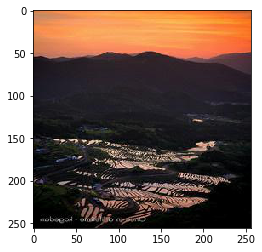

In [51]:
image_print(real_photo)

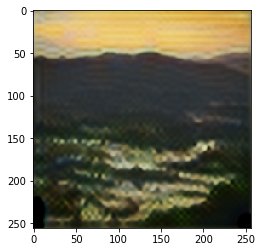

In [52]:
image_print(gan_photo)

In [ ]:
# Epoch: 0 Gan_loss: None D_A_loss: None D_B_loss: Nonetime: 0.00000
# Epoch: 1 Gan_loss: 7.813969612121582 D_A_loss: 0.10488978773355484 D_B_loss: 0.07457364350557327time: 0.00474
# Epoch: 2 Gan_loss: 5.00911808013916 D_A_loss: 0.14342588186264038 D_B_loss: 0.06400832533836365time: 0.00437
# Epoch: 3 Gan_loss: 7.4770917892456055 D_A_loss: 0.11205624043941498 D_B_loss: 0.06319641321897507time: 0.00414
# Epoch: 4 Gan_loss: 4.552962779998779 D_A_loss: 0.09382851421833038 D_B_loss: 0.0986352190375328time: 0.00449
# Epoch: 5 Gan_loss: 6.753692626953125 D_A_loss: 0.20653259754180908 D_B_loss: 0.07010902464389801time: 0.00429
# Epoch: 6 Gan_loss: 5.623927116394043 D_A_loss: 0.0828545019030571 D_B_loss: 0.14706969261169434time: 0.00401
# Epoch: 7 Gan_loss: 5.653323173522949 D_A_loss: 0.12696056067943573 D_B_loss: 0.06830567866563797time: 0.00434

# Epoch: 7 Gan_loss: None D_A_loss: None D_B_loss: Nonetime: 0.00000
# Epoch: 8 Gan_loss: 5.0473737716674805 D_A_loss: 0.12709523737430573 D_B_loss: 0.11123944818973541time: 0.00454
# Epoch: 9 Gan_loss: 5.641348361968994 D_A_loss: 0.09496762603521347 D_B_loss: 0.06243462115526199time: 0.00414
# Epoch: 10 Gan_loss: 4.926997184753418 D_A_loss: 0.16662858426570892 D_B_loss: 0.11674116551876068time: 0.00459
# Epoch: 11 Gan_loss: 4.9881463050842285 D_A_loss: 0.08113554120063782 D_B_loss: 0.10177332162857056time: 0.00473
# Epoch: 12 Gan_loss: 4.131355285644531 D_A_loss: 0.13846881687641144 D_B_loss: 0.1533401906490326time: 0.00380

# Epoch: 13 Gan_loss: None D_A_loss: None D_B_loss: Nonetime: 0.00000
# Epoch: 14 Gan_loss: 3.776794672012329 D_A_loss: 0.07640881836414337 D_B_loss: 0.18081530928611755time: 0.00454
# Epoch: 15 Gan_loss: 3.6436781883239746 D_A_loss: 0.16835659742355347 D_B_loss: 0.14823246002197266time: 0.00479
# Epoch: 16 Gan_loss: 3.5346579551696777 D_A_loss: 0.054177772253751755 D_B_loss: 0.12535707652568817time: 0.00462
# Epoch: 17 Gan_loss: 5.40281867980957 D_A_loss: 0.13855545222759247 D_B_loss: 0.08977721631526947time: 0.00430
# Epoch: 18 Gan_loss: 4.969257354736328 D_A_loss: 0.14582467079162598 D_B_loss: 0.0983186885714531time: 0.00401
# Epoch: 19 Gan_loss: 4.424161434173584 D_A_loss: 0.09731912612915039 D_B_loss: 0.09710921347141266time: 0.00431
# Epoch: 20 Gan_loss: 4.634834289550781 D_A_loss: 0.1389487236738205 D_B_loss: 0.10056305676698685time: 0.00414

# Epoch: 20 Gan_loss: None D_A_loss: None D_B_loss: Nonetime: 0.00000
# Epoch: 21 Gan_loss: 3.8682029247283936 D_A_loss: 0.08231814950704575 D_B_loss: 0.16989301145076752time: 0.00391
# Epoch: 22 Gan_loss: 3.5043585300445557 D_A_loss: 0.14648790657520294 D_B_loss: 0.16529817879199982time: 0.00383
# Epoch: 23 Gan_loss: 4.695670127868652 D_A_loss: 0.18481998145580292 D_B_loss: 0.07825784385204315time: 0.00368